# 📦 Import Libraries

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# **ML & NLP Libraries**

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2

ML Models and Evaluation

In [170]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


Load Dataset

In [171]:
fake_df = pd.read_csv("Fake.csv")
print(f"Fake.csv shape: {fake_df.shape[0]} rows, {fake_df.shape[1]} columns")
true_df = pd.read_csv("True.csv")
print(f"True.csv shape: {true_df.shape[0]} rows, {true_df.shape[1]} columns")

Fake.csv shape: 23481 rows, 4 columns
True.csv shape: 21417 rows, 4 columns
True.csv shape: 21417 rows, 4 columns


Add labels

In [172]:
fake_df['label'] = 0  # Fake
true_df['label'] = 1  # True

Combine Dataset

In [173]:
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
print(f"Combined dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")

Combined dataset shape: 44898 rows, 5 columns


 Data Preprocessing

In [174]:
# Drop nulls if any
df.dropna(inplace=True)

# Combine title + text (optional)
df['content'] = df['title'] + " " + df['text']
df['content'] = df['content'].str.lower().str.replace(r"[^a-zA-Z\s]", "", regex=True)

In [175]:
print("Missing values in each column:")
print(df.isnull().sum())
print("\nPercentage of missing values in each column:")
print((df.isnull().mean() * 100).round(2))

Missing values in each column:
title      0
text       0
subject    0
date       0
label      0
content    0
dtype: int64

Percentage of missing values in each column:
title      0.0
text       0.0
subject    0.0
date       0.0
label      0.0
content    0.0
dtype: float64


Fix Outliers

In [176]:
min_length = 10
initial_count = len(df)
df = df[df['content'].str.len() >= min_length]
print(f"Removed {initial_count - len(df)} rows with empty or very short content (less than {min_length} characters).")

max_length = df['content'].str.len().quantile(0.99)
df['content'] = df['content'].apply(lambda x: x[:int(max_length)])
print(f"Capped article length at {int(max_length)} characters (99th percentile).")

Removed 0 rows with empty or very short content (less than 10 characters).
Capped article length at 9044 characters (99th percentile).


Features & Labels

In [177]:
X = df['content']
y = df['label']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

🔹 Feature Selection

In [178]:
selector = SelectKBest(chi2, k=5000)
X_train_sel = selector.fit_transform(X_train_vec, y_train)
X_test_sel = selector.transform(X_test_vec)

🔹 Normalization

In [179]:
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

Model Setup

In [180]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

results = {}

 Training & Evaluation

In [181]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📌 {name}")
    print("Accuracy:", acc)
    print("Precision:", pre)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    results[name] = [acc, pre, rec, f1]


📌 Random Forest
Accuracy: 0.998218262806236
Precision: 0.9983652498832322
Recall: 0.9978991596638656
F1 Score: 0.9981321503618958
Confusion Matrix:
 [[4689    7]
 [   9 4275]]

📌 Logistic Regression
Accuracy: 0.995879732739421
Precision: 0.9957973383142658
Recall: 0.9955648926237162
F1 Score: 0.9956811019026497
Confusion Matrix:
 [[4678   18]
 [  19 4265]]

📌 Logistic Regression
Accuracy: 0.995879732739421
Precision: 0.9957973383142658
Recall: 0.9955648926237162
F1 Score: 0.9956811019026497
Confusion Matrix:
 [[4678   18]
 [  19 4265]]

📌 KNN
Accuracy: 0.7047884187082405
Precision: 0.9695227142035653
Recall: 0.39355742296918766
F1 Score: 0.5598538934086004
Confusion Matrix:
 [[4643   53]
 [2598 1686]]

📌 KNN
Accuracy: 0.7047884187082405
Precision: 0.9695227142035653
Recall: 0.39355742296918766
F1 Score: 0.5598538934086004
Confusion Matrix:
 [[4643   53]
 [2598 1686]]

📌 Decision Tree
Accuracy: 0.9957683741648107
Precision: 0.9957963568425969
Recall: 0.9953314659197012
F1 Score: 0.9955

 🔹 Ensemble: Voting Classifier

In [182]:
voting_model = VotingClassifier(
    estimators=[
        ('rf', models["Random Forest"]),
        ('lr', models["Logistic Regression"]),
        ('dt', models["Decision Tree"])
    ],
    voting='hard'
)
voting_model.fit(X_train_scaled, y_train)
y_vote = voting_model.predict(X_test_scaled)

model_names = []
for name, model in voting_model.estimators:
    if isinstance(model, RandomForestClassifier):
        model_names.append("Random Forest")
    elif isinstance(model, LogisticRegression):
        model_names.append("Logistic Regression")
    elif isinstance(model, KNeighborsClassifier):
        model_names.append("KNN")
    elif isinstance(model, DecisionTreeClassifier):
        model_names.append("Decision Tree")
    else:
        model_names.append(name)

# Evaluate all models to find the best one
best_model = None
best_f1 = -1
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_model = name

print(f"\n📌 Ensemble Voting Classifier (Models: {', '.join(model_names)})")
print("Accuracy:", accuracy_score(y_test, y_vote))
print("F1 Score:", f1_score(y_test, y_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_vote))
print(f"\n🏆 Best Individual Model: {best_model} (F1 Score: {best_f1:.4f})")


📌 Ensemble Voting Classifier (Models: Random Forest, Logistic Regression, Decision Tree)
Accuracy: 0.9986636971046771
F1 Score: 0.9986000933271115
Confusion Matrix:
 [[4688    8]
 [   4 4280]]

🏆 Best Individual Model: Random Forest (F1 Score: 0.9981)


Visualization:

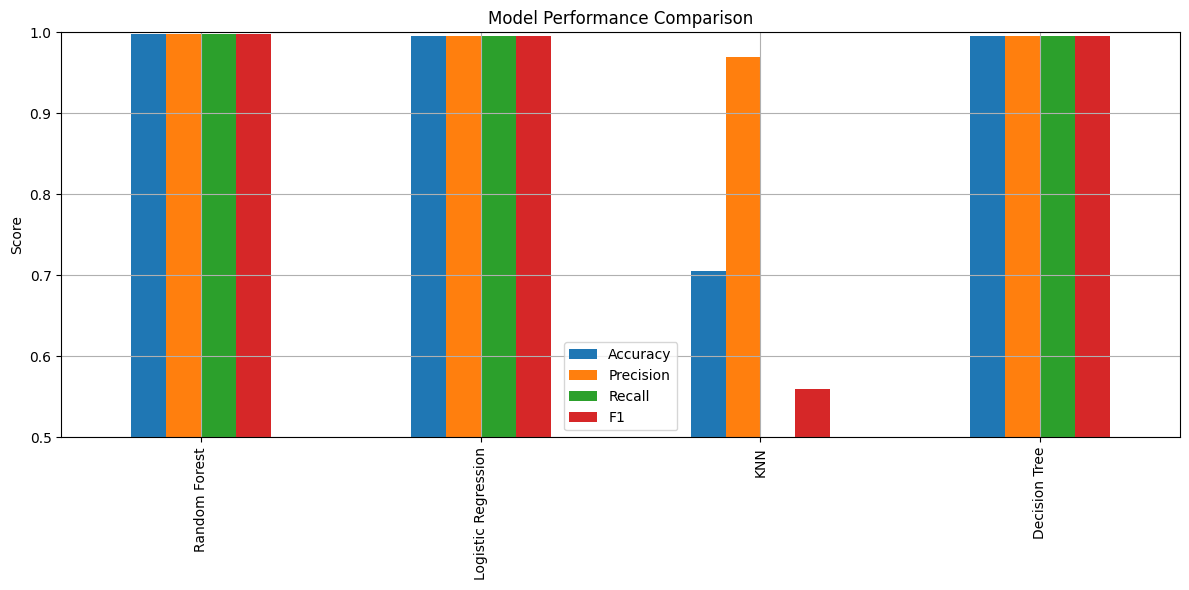

In [140]:
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1"]).T
results_df.plot(kind='bar', figsize=(12, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

Check Model-Fit

In [141]:
# Loop through models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy metrics
    train_acc = model.score(X_train_scaled, y_train)
    test_acc = model.score(X_test_scaled, y_test)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n📌 {name}")
    print("Training Accuracy:", round(train_acc, 4))
    print("Testing Accuracy :", round(test_acc, 4))
    print("Precision         :", round(pre, 4))
    print("Recall            :", round(rec, 4))
    print("F1 Score          :", round(f1, 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Save results
    results[name] = [acc, pre, rec, f1]

    # Overfit/Underfit Check
    print("🔍 Fit Check:", end=" ")
    if train_acc > 0.95 and (train_acc - test_acc) > 0.10:
        print("⚠️ Overfitting detected.")
    elif train_acc < 0.75 and test_acc < 0.75:
        print("⚠️ Underfitting detected.")
    else:
        print("✅ Model is well-fitted.")



📌 Random Forest
Training Accuracy: 1.0
Testing Accuracy : 0.9984
Precision         : 0.9979
Recall            : 0.9988
F1 Score          : 0.9984
Confusion Matrix:
 [[4687    9]
 [   5 4279]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 Logistic Regression
Training Accuracy: 1.0
Testing Accuracy : 0.9959
Precision         : 0.9958
Recall            : 0.9956
F1 Score          : 0.9957
Confusion Matrix:
 [[4678   18]
 [  19 4265]]
🔍 Fit Check: ✅ Model is well-fitted.

📌 Logistic Regression
Training Accuracy: 1.0
Testing Accuracy : 0.9959
Precision         : 0.9958
Recall            : 0.9956
F1 Score          : 0.9957
Confusion Matrix:
 [[4678   18]
 [  19 4265]]
🔍 Fit Check: ✅ Model is well-fitted.


KeyboardInterrupt: 

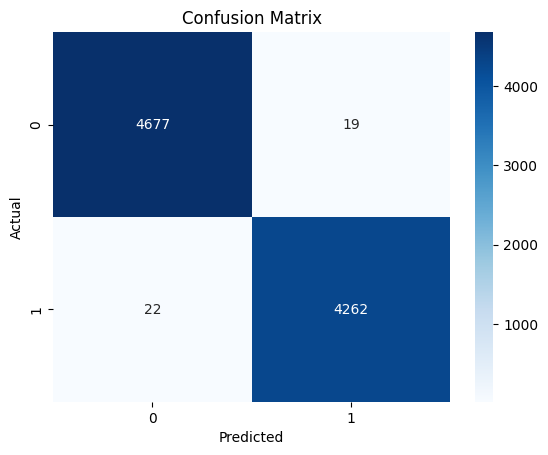

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()